In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import tsunamibayes as tb
from tsunamibayes.fault import ReferenceCurveFault
from tsunamibayes.multifault import MultiFault
from tsunamibayes.utils import bearing, haversine

In [2]:
# %matplotlib notebook

In [3]:
plt.style.use('seaborn')

In [4]:
def convert_lat_lon(lat, lon):
    """Converts latitude and longitude from strings to decimals.
    Proper string form: '8-17-43.21S', '118-43-42.00E' etc.
    """
    latitude = sum(float(x) / 60 ** n for n, x in enumerate(lat[:-1].split('-')))  * (1 if 'N' == lat[-1] else -1)
    longitude = sum(float(x) / 60 ** n for n, x in enumerate(lon[:-1].split('-'))) * (1 if 'E' == lon[-1] else -1)
    return latitude, longitude

In [42]:
# Import and plot flores trench earthquake data
flores_new = pd.read_excel('/Users/paskett/Downloads/Flores Trench Earthquake data 5-7.2.xlsx')
flores_new['Unnamed: 2']

0                   NaN
1           Coordinates
2     8.062°S 125.300°E
3     8.081°S 125.129°E
4     8.152°S 124.868°E
5     8.099°S 124.681°E
6     8.899°S 123.542°E
7     8.480°S 121.896°E
8     8.232°S 121.438°E
9     8.294°S 120.743°E
10    8.100°S 120.231°E
11    8.141°S 119.504°E
12    8.261°S 118.753°E
13    8.207°S 118.631°E
14    8.224°S 118.467°E
15    8.292°S 118.370°E
16    8.197°S 118.341°E
17    8.319°S 116.627°E
18    8.337°S 116.599°E
19    8.240°S 116.508°E
20    8.258°S 116.438°E
21    8.207°S 115.949°E
22    8.390°S 115.889°E
23    8.254°S 115.847°E
24    8.170°S 114.888°E
Name: Unnamed: 2, dtype: object

## Get the fault data -- latitudes/longitudes and strike data

In [5]:
# Get latitude and longitude of faults.

use_hypo = False # I think the Hypo data is wrong -- everything seems shifted too far left on the Walanae fault.
if not use_hypo:
    flores = pd.read_excel('1820_fault_data/FloresThrustSplit_TableToExcel.xlsx')
    walanae = pd.read_excel('1820_fault_data/WalinaeFaultSplit_TableToExcel.xlsx')
    flores_lats, flores_lons = flores[['CenterLat', 'CenterLong']].to_numpy().T
    walanae_lats, walanae_lons = walanae[['CenterLat', 'CenterLong']].to_numpy().T
else:
    flores = pd.read_excel('1820_fault_data/FloresHypoSegments.xlsx')
    walanae = pd.read_excel('1820_fault_data/WalanaeHypoSegments.xlsx')
    flores_lats, flores_lons = flores[['Lat', 'Long']].to_numpy().T
    walanae_lats, walanae_lons = walanae[['Lat', 'Long']].to_numpy().T

In [6]:
# Get a couple of lat/lon for gauges.
bima_latlon =  convert_lat_lon('8-27-43.21S', '118-43-42.00E')
makassar_latlon = convert_lat_lon('5-7-30.27S', '119-27-56.45E')

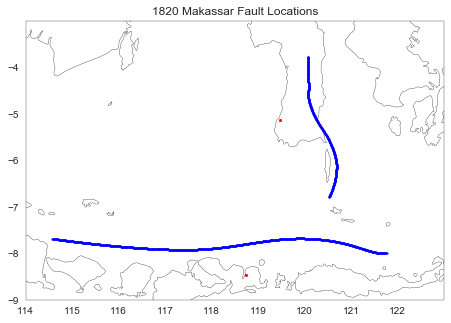

In [11]:
# Plot the fault data.
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(7.5,7))
ax = plt.axes(projection=crs)
ax.set_extent((114,123,-9,-3))
ax.coastlines(resolution='10m')
plt.xticks(np.arange(114,123))
plt.yticks(np.arange(-9,-3))

# Plot the Bima and Makassar gauges.
plt.scatter([bima_latlon[1], makassar_latlon[1]],[bima_latlon[0], makassar_latlon[0]], s=8, c='r')

# Plot the fault data that we already have.
plt.scatter(np.append(flores_lons, walanae_lons), np.append(flores_lats, walanae_lats), s=3, c='b')

plt.title("1820 Makassar Fault Locations")
plt.show()

## Test the ReferenceCurveFault and MultiFault classes on this data

In [7]:
# Get the strike, dip, and depth data needed to initialize ReferenceCurveFaults.
walanae_strikes = walanae['Strike'].to_numpy()
# Dip angle assumed to be 25 degrees.
walanae_dip = lambda x: 25 # FIXME: is dip fixed no matter how far we get from the fault?
# Depths are assumed to be 25 km.
def walanae_depth(dist):
    """Gives depth based on distance from fault. 
    A negative distance is higher than the base fault depth.
    """
    base_depth = 25000
    extra_depth = dist*np.tan(np.deg2rad(walanae_dip(dist)))
    return base_depth - extra_depth

walanae_bounds = {'lonmin':118, 'lon_max':122, 'lat_min': -7.5, 'lat_max': -3}

# Now do the same for flores fault.
flores_strikes = flores['Strike'].to_numpy()
# "Check for fault plane solutions" ?, we will guess dip of 32.5 degrees
flores_dip = lambda x: 32.5 # FIXME: The dip will be fixed at any point, right?
def flores_depth(dist):
    """Gives depth based on distance from fault. 
    A negative distance is higher than the base fault depth.
    """
    base_depth = 25000 #FIXME: should this be assumed at 25 km also?
    extra_depth = dist*np.tan(np.deg2rad(flores_dip(dist)))
    return base_depth - extra_depth
    
flores_bounds = {'lonmin':114, 'lon_max':123, 'lat_min': -8.5, 'lat_max': -7}

In [8]:
dist = 10000
dist*np.tan(np.deg2rad(walanae_dip(dist)))

4663.076581549986

In [9]:
# Create ReferenceCurveFaults for Walanae and Flores faults.
walanae_rcf = ReferenceCurveFault(
    walanae_lats, 
    walanae_lons,
    walanae_strikes, 
    walanae_depth, 
    walanae_dip,
    walanae_bounds)
flores_rcf = ReferenceCurveFault(
    flores_lats, 
    flores_lons,
    flores_strikes, 
    flores_depth, 
    flores_dip,
    flores_bounds)

In [10]:
# Let's try testing the depths over different latitude and longitude locations.
lats = np.linspace(-9,-7,300)
lons = np.linspace(114,123,100)
X,Y = np.meshgrid(lats, lons)
Z = flores_rcf.depth_map(
    X.flatten()[:,np.newaxis],
    Y.flatten()[:,np.newaxis], 
    True
)
Z

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable deg2rad method

In [12]:
lat = X.flatten()[:,np.newaxis]
lon = Y.flatten()[:,np.newaxis]

distance,idx = flores_rcf.distance(lat,lon,retclose=True)

# side = ReferenceCurveFault.side(
#     lat,
#     lon,
#     flores_rcf.latpts[idx],
#     flores_rcf.lonpts[idx],
#     flores_rcf.strikepts[idx]
# )

fault_lat = flores_rcf.latpts[idx]
fault_lon = flores_rcf.lonpts[idx]
strike = flores_rcf.strikepts[idx]

fault_lat = fault_lat.reshape(lat.shape)
fault_lon = fault_lon.reshape(lon.shape)
strike = strike.reshape(lat.shape)

In [13]:
sides = np.empty(lat.shape)

mask1 = (0 <= (strike+45)%360) & ((strike+45)%360 < 90)
sides[mask1] = np.sign((lon[mask1]-fault_lon[mask1]+180)%360-180)

mask2 = (90 <= (strike+45)%360) & ((strike+45)%360 < 180)
sides[mask2] = -np.sign(lat[mask2]-fault_lat[mask2])

mask3 = (180 <= (strike+45)%360) & ((strike+45)%360 < 270)
sides[mask3] = -np.sign((lon[mask3]-fault_lon[mask3]+180)%360-180)

mask4 = ~(mask1 | mask2 | mask3)
sides[mask4] = np.sign(lat[mask4]-fault_lat[mask4])

In [38]:
def bearing(lat1, lon1, lat2, lon2):
    """Compute the bearing between two points.
    All of the following parameters must have the same dimension.

    Parameters
    ----------
    lat1 : float -or- array_like of floats
        The coordinate or ndarray of coordinates associated with the initial latitude.
    lon1 : float -or- array_like of floats
        The coordinate or ndarray of coordinates associated with the initial longitude.
    lat2 : float -or- array_like of floats
        The coordinate or ndarray of coordinates associated with the terminal latitude.
    lon1 : float -or- array_like of floats
        The coordinate or ndarray of coordinates associated with the terminal latitude.

    Returns
    -------
    bearing : float -or- ndarray of floats
        The computed bearing (in degrees) between the given point(s).
        Returns object of the same dimension as the lat/lon parameters.
    """
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    x = np.cos(lat2)*np.sin(lon2-lon1)
    y = np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1)
    return np.degrees(np.arctan2(x,y))%360

side = sides.copy()
mask = (idx == 0) | (idx == (len(flores_rcf.latpts)-1))
bear = bearing(lat[idx[mask]],lon[idx[mask]],flores_rcf.latpts[idx[mask]],flores_rcf.lonpts[idx[mask]])

In [31]:
temp = np.sin(np.deg2rad(flores_rcf.strikepts[idx[mask]]-bear))

In [33]:
(distance[mask]*temp).shape

(30000, 6114)

In [34]:
distance[mask].shape

(6114,)

In [ ]:
side[mask] = -np.sign(distance[idx[mask]])
distance[mask] = np.abs(distance[idx[mask]])

depth = flores_rcf.depth_curve(side*distance)
depth

In [27]:
distance[mask].shape

(6114,)

In [28]:
np.deg2rad((flores_rcf.strikepts[idx[mask]] - bear)).shape

(30000, 6114)

In [15]:
lon.shape

(30000, 1)

In [ ]:
np.deg2rad?

In [ ]:
flores_rcf.latpts.shape

In [ ]:
sides2 = np.zeros(sides.shape)

In [ ]:
for idx,(lt,ln,flat,flon,strk) in enumerate(zip(lat,lon,fault_lat,fault_lon,strike)):
    sides2[idx] = ReferenceCurveFault.side(lt,ln,flat,flon,strk)

In [ ]:
np.all(sides2 == sides)

In [ ]:
dists, idx = flores_rcf.distance(X.flatten()[:,np.newaxis],Y.flatten()[:,np.newaxis], True)

In [ ]:
dists.shape

In [ ]:
flores_rcf.strikepts[idx]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,Z.reshape(100,300))

In [ ]:
dists = np.linspace(-20,20,100)
plt.plot(flores_depth(dists))
plt.show()

In [ ]:
.min()

In [ ]:
mask1 = np.array([False, False, True, True])
mask2 = np.array([True, False, False, False])

In [ ]:
~(mask1 | mask2)